# AQC-Tensor workflow setup in Qiskit, covering initialisation of a Hamiltonian, generation of Trotter circuits, and transpilation of the final optimized circuit for a target device. Heisenberg models

Small scale 10-site XXZ model

Hamiltonian: SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII'],
              coeffs=[1.        +0.j, 0.52440675+0.j, 0.52440675+0.j, 1.0488135 +0.j,
 0.60759468+0.j, 0.60759468+0.j, 1.21518937+0.j, 0.55138169+0.j,
 0.55138169+0.j, 1.10276338+0.j, 0.52244159+0.j, 0.52244159+0.j,
 1.04488318+0.j, 0.4618274 +0.j, 0.4618274 +0.j, 0.9236548 +0.j,
 0.57294706+0.j, 0.57294706+0.j, 1.14589411+0.j, 0.46879361+0.j,
 0.46879361+0.j, 0.93758721+0.j, 0.6958865 +0.j, 0.6958865 +0.j,
 1.391773  +0.j, 0.73183138+0.j, 0.73183138+0.j, 1.46366276+0.j])
Observable: SparsePauliOp(['IIIIZZIIII'],
              coeffs=[1.+0.j])


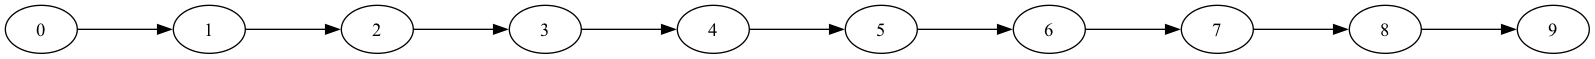

In [1]:
# set up coupling map, hamiltonian, observable
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw
import numpy as np

# L is the number of sites, also the length of the 1D spin chain
L = 10  

# Generate the coupling map
elist = [(i - 1, i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges = elist[::2]
odd_edges = elist[1::2]
coupling_map = CouplingMap(elist)

# Generate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)
hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

# Generate a ZZ observable between the two middle qubits
observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

print("Hamiltonian:", hamiltonian)
print("Observable:", observable)
graphviz_draw(coupling_map.graph, method="circo")

In [ ]:
# extract hamiltonian for TN analysis, not best wya, probably better to build hamiltonaina directly  but works
from ropt_aqc.initialise_hamiltonians import extract_two_qubit_hamiltonians
H = extract_two_qubit_hamiltonians(hamiltonian) 

In [4]:
from ropt_aqc.circuit_building import get_brickwall_trotter_gates_generic

gates = get_brickwall_trotter_gates_generic(t=2.0, n_sites=L, n_repetitions=1, degree=2, use_TN=False, hamiltonian_terms=H)
print(gates)

[[[ 0.6029084 -0.79781044j  0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.36349848+0.4810066j
    0.6365015 -0.4810066j   0.        +0.j        ]
  [ 0.        +0.j          0.6365015 -0.4810066j
    0.36349848+0.4810066j   0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j
    0.        +0.j          0.6029084 -0.79781044j]]

 [[ 0.50200295-0.8648659j   0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.25200698+0.43416524j
    0.74799305-0.43416524j  0.        +0.j        ]
  [ 0.        +0.j          0.74799305-0.43416524j
    0.25200698+0.43416524j  0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j
    0.        +0.j          0.50200295-0.8648659j ]]

 [[ 0.45113164-0.8924574j   0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.20351976+0.4026158j
    0.79648024-0.4026158j   0.        +0.j        ]
  [ 0.   

In [2]:
# construct initial state
from qiskit import QuantumCircuit

# Generate an initial state
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

In [3]:
# initial time evolution
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

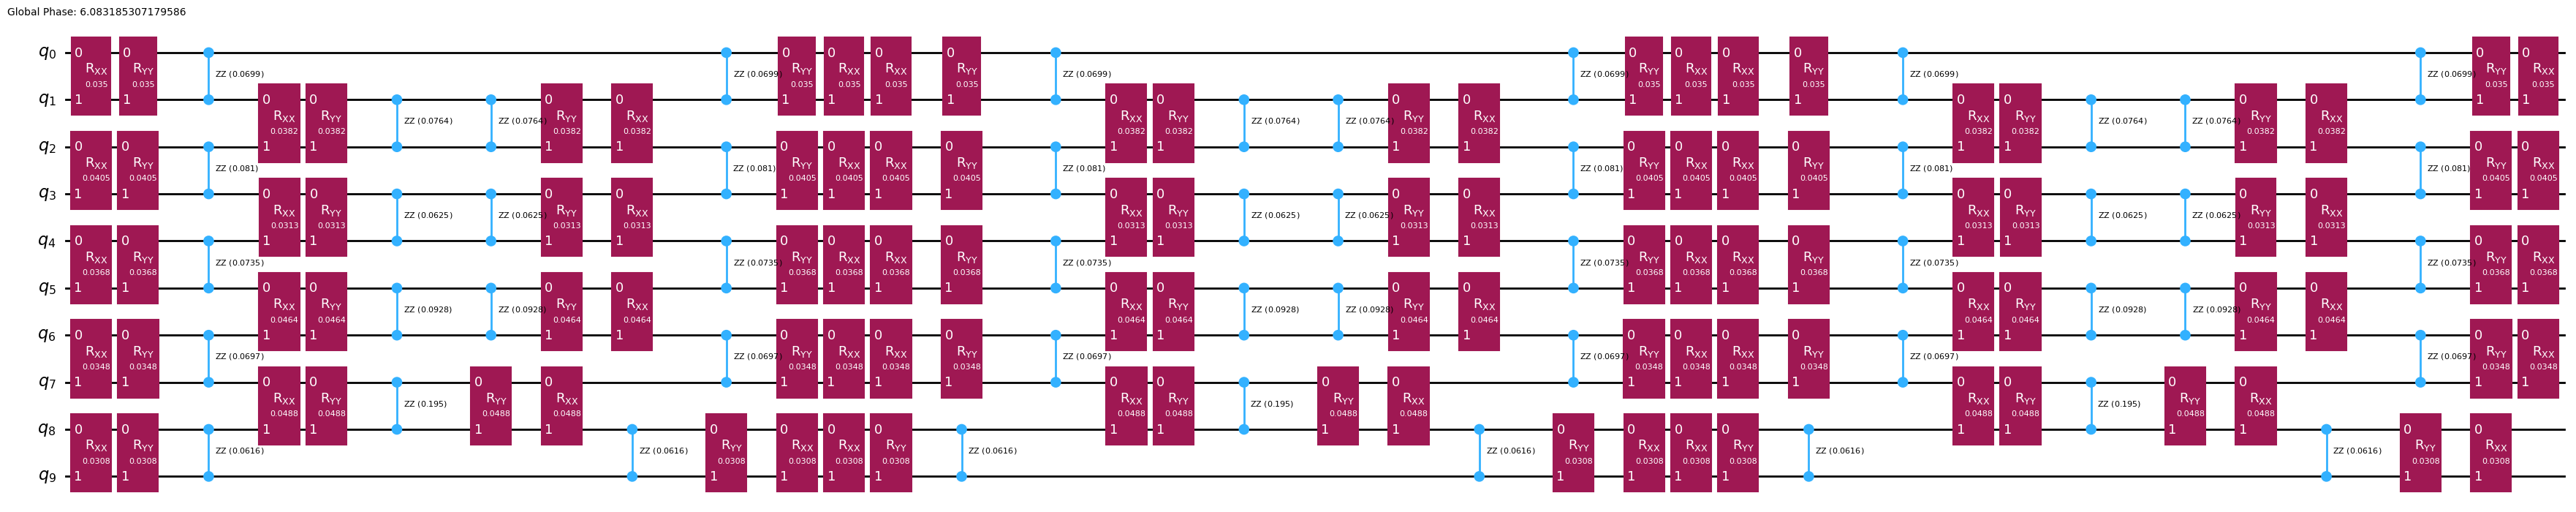

In [4]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

In [5]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


In [6]:
# Generate the reference circuit
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

Generate an ansatz and initial parameteres from a Trotter circuit with fewer steps



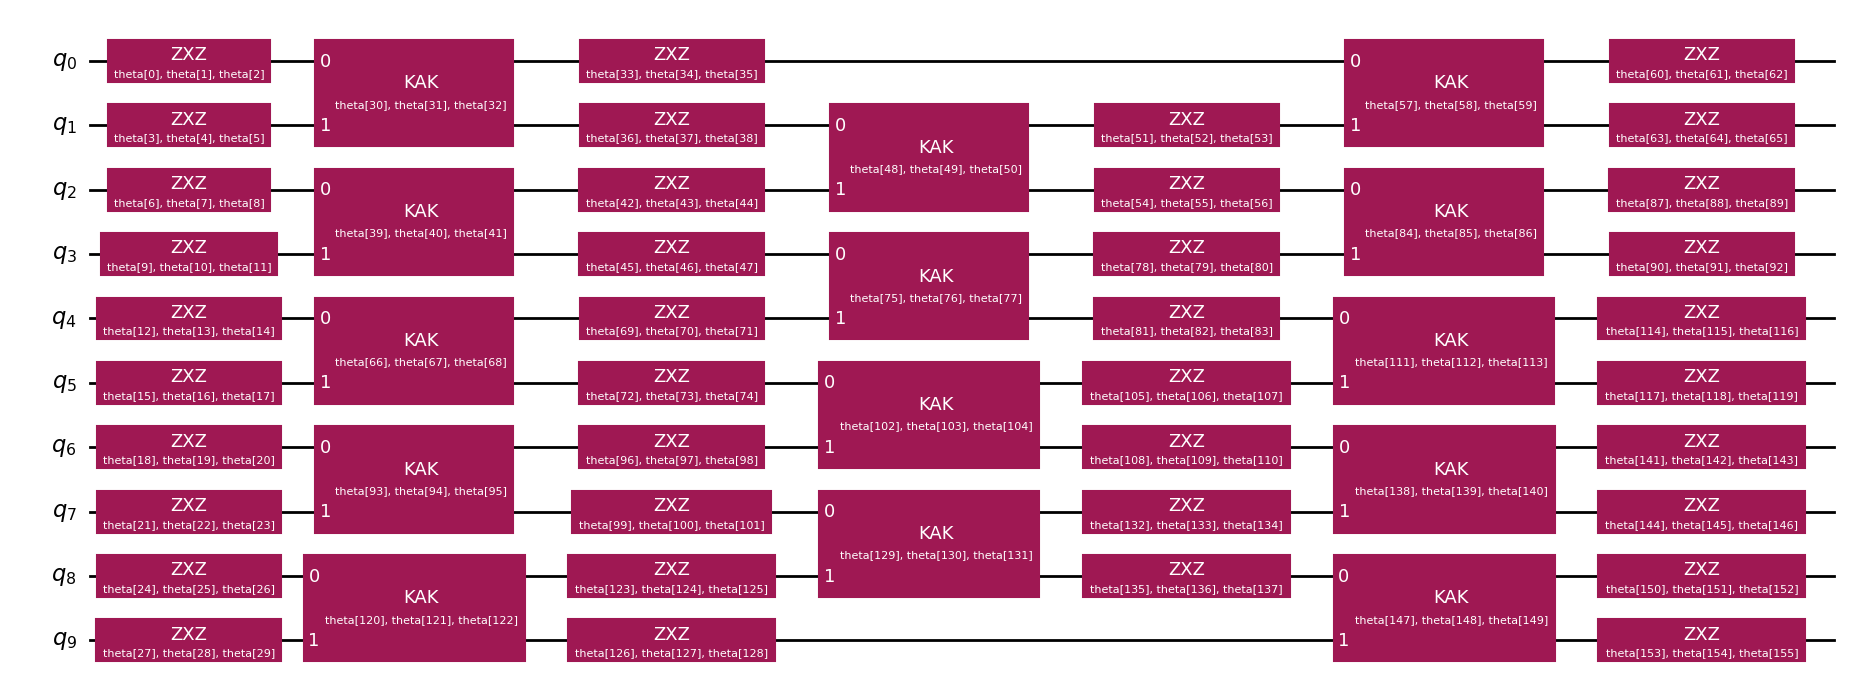

In [7]:
from qiskit_addon_aqc_tensor.ansatz_generation import generate_ansatz_from_circuit

aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(aqc_good_circuit)
aqc_ansatz.draw("mpl", fold=-1)

In [41]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 156 parameters


Choose Settings for Tensor Network Simulation



In [42]:
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")

In [43]:
# generate MPS representation of the target state, handles efficiently the entanglement
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examing the `local_expectation``
reference_mps  = tensornetwork_from_circuit(reference_circuit, simulator_settings)
reference_expval = reference_mps.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (L // 2 - 1, L // 2)).real.item()
print("Reference MPS maximum bond dimension:", reference_mps.psi.max_bond())

Target MPS maximum bond dimension: 5
Reference MPS maximum bond dimension: 7


In [ ]:
# evaluate the fidelity between the state prepared by the initial cirucit and the target state
from qiskit_addon_aqc_tensor.simulation import compute_overlap

good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Starting fidelity: 0.9982464959067983


In [45]:
# optimise the ansatz parameters
import datetime
from scipy.optimize import OptimizeResult, minimize
from qiskit_addon_aqc_tensor.objective import OneMinusFidelity

# Setting values for the optimization
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration
    
result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_24638/2594569749.py:11: DeprecationWarning: The class ``qiskit_addon_aqc_tensor.objective.OneMinusFidelity`` is deprecated as of qiskit-addon-aqc-tensor 0.2.0. It will be removed no earlier than v0.4.0. This class has been renamed to ``MaximizeStateFidelity``.
  objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)


2025-04-01 14:28:56.779804 Intermediate result: Fidelity 0.99952858
2025-04-01 14:28:56.786640 Intermediate result: Fidelity 0.99958448
2025-04-01 14:28:56.793276 Intermediate result: Fidelity 0.99960033
2025-04-01 14:28:56.799486 Intermediate result: Fidelity 0.99960927
2025-04-01 14:28:56.806039 Intermediate result: Fidelity 0.99962381
2025-04-01 14:28:56.813128 Intermediate result: Fidelity 0.99964360
2025-04-01 14:28:56.819920 Intermediate result: Fidelity 0.99968186
2025-04-01 14:28:56.834128 Intermediate result: Fidelity 0.99970593
2025-04-01 14:28:56.842552 Intermediate result: Fidelity 0.99973871
2025-04-01 14:28:56.848751 Intermediate result: Fidelity 0.99975361
2025-04-01 14:28:56.854700 Intermediate result: Fidelity 0.99976589
2025-04-01 14:28:56.859963 Intermediate result: Fidelity 0.99977626
2025-04-01 14:28:56.866346 Intermediate result: Fidelity 0.99978698
2025-04-01 14:28:56.873279 Intermediate result: Fidelity 0.99980141
2025-04-01 14:28:56.879399 Intermediate result: 

In [46]:
parameters = [float(param) for param in aqc_final_parameters]
print("Final parameters:", parameters)

Final parameters: [-7.8539776652190305, 1.5707990082211734, 1.5707953847366678, -1.5707924382269065, 1.5707958733721588, 1.5707963027782796, -1.5707946131859631, 1.5707950550765424, -1.5707967516364902, -1.5707941255666495, 1.5707970055747582, 4.712387263858426, -7.853987129909075, 1.570795576679184, 1.5707950068803613, -1.570797061908127, 1.5707945771303853, 1.5707963971464445, -1.5707962373755078, 1.570794100414977, -1.5707982322360545, -1.5707961854877335, 1.5707955429784495, 4.712387587718153, -1.5708011595100448, 1.5707938621683752, -1.5707987797076617, -1.5708000432105091, 1.570796153248353, 4.712387251448976, 0.10487302231274286, 0.0669703129899824, -0.06697594049453545, -3.1415919170312403, 2.6096189616000953, -1.749270033364245e-06, -3.141592206043033, 0.9420417814222034, 6.078869091947212e-08, 0.12151228524376213, 0.07974691352147122, -0.07974821142877335, -3.141593195142849, 0.9740120218505509, 3.1415908744208783, 5.714850804595926e-07, 1.7899059277598859, -2.613406250079926

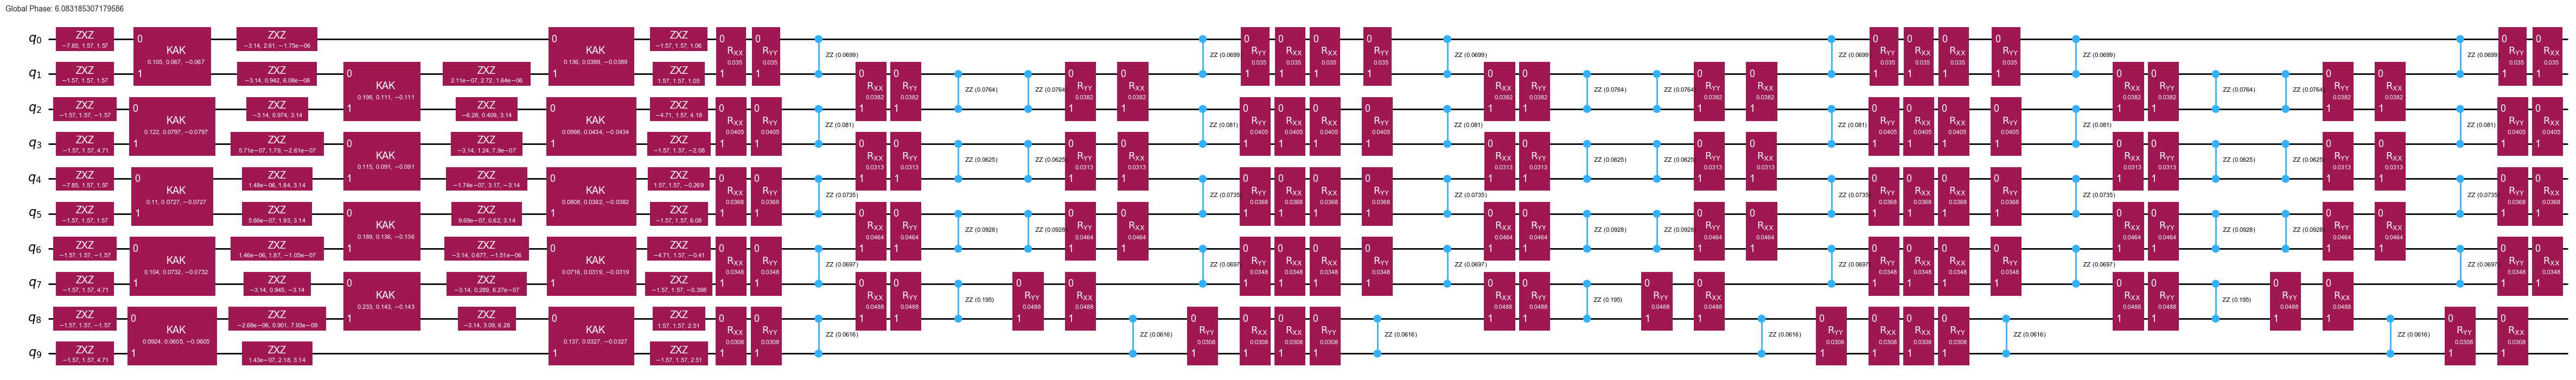

In [47]:
# complete time evolution cirucit for execution on hardware
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)
aqc_final_circuit.draw("mpl", fold=-1)

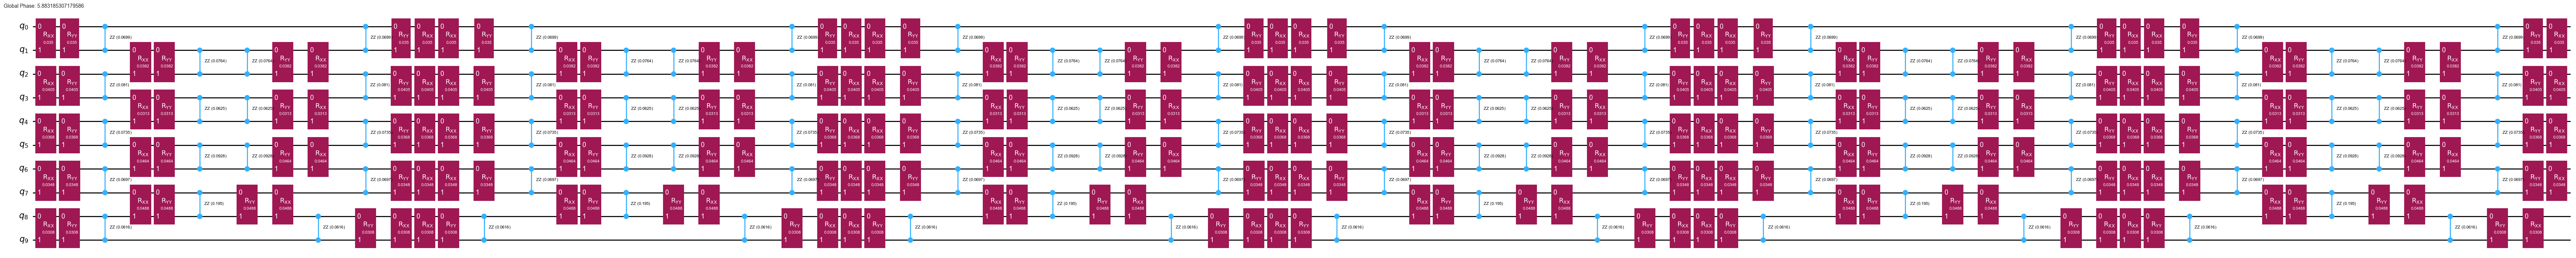

In [48]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

Optimise problem for quanutm execution

In [49]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_kyiv')>


Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 114


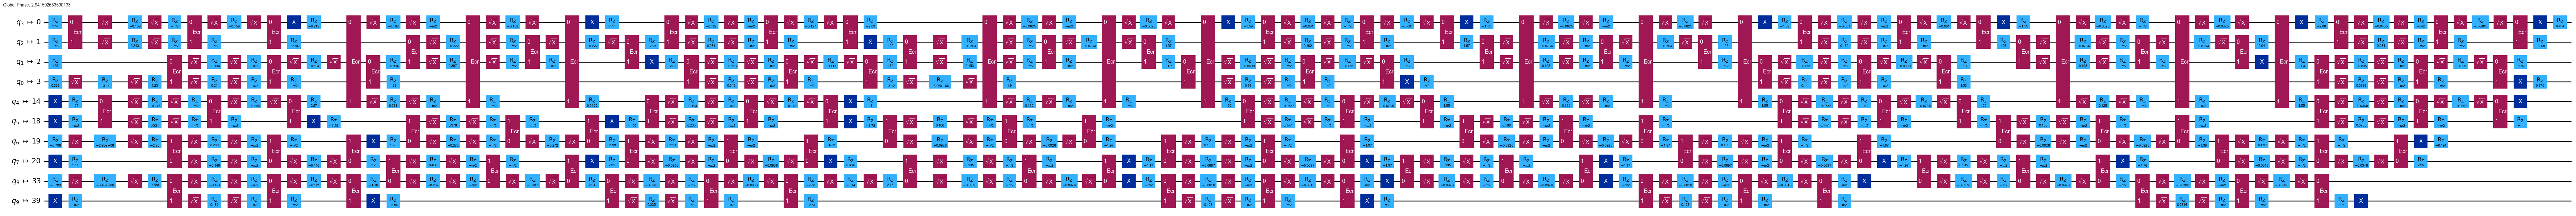

In [50]:
# transpiler optimises cirucit to fit a 1D chain of qubits, reducing the noise impacting the cirucit fidelity
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 158


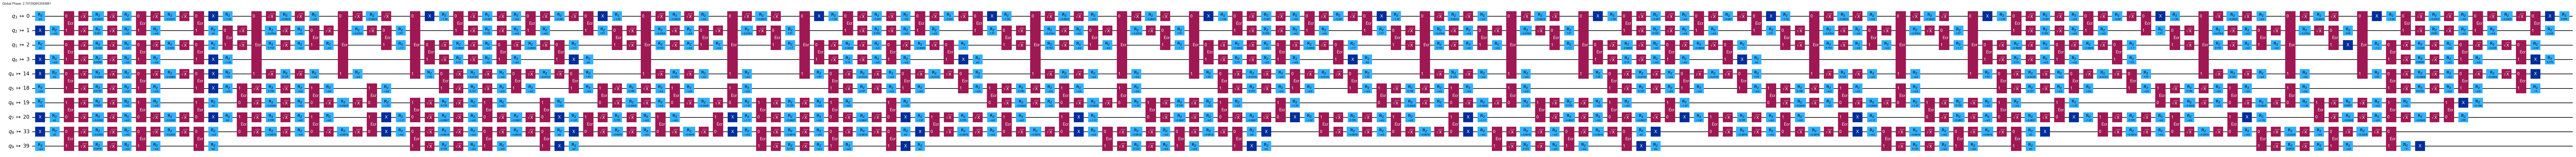

In [51]:
# transpilation for the comparison cirucit
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

Execute using Qiskit primitives

In [52]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: cznxrjjrxz8g008dhp80


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [53]:
# for the comparison cirucit
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: cznxrjjrxz8g008dhp80


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

Post-processing

In [54]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.5252
AQC:           	-0.2483, |∆| = 0.2770
AQC Comparison:	0.6003, |∆| = 1.1256


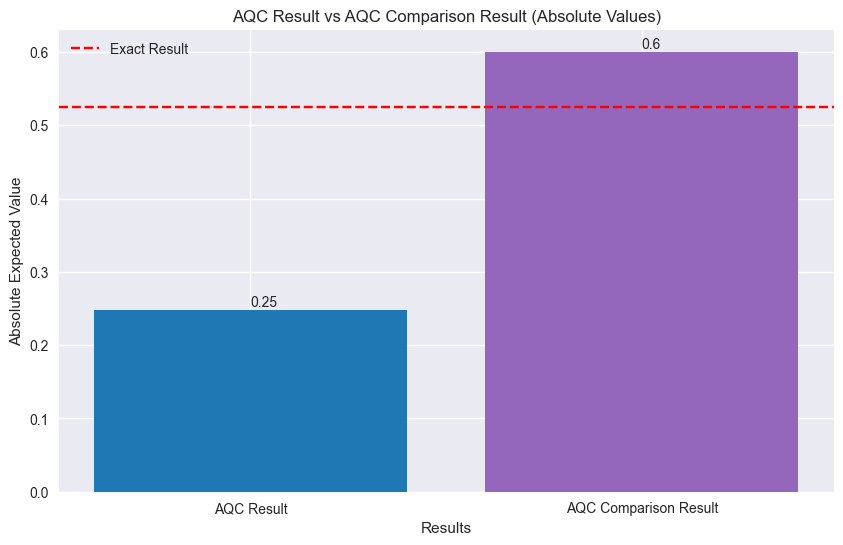

In [55]:
# Bar plot to comapre results
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  
plt.show()

50-site XXZ model

In [57]:
L = 50  # L = length of our 1D spin chain

# Generate the edge-list for this spin-chain
elist = [(i - 1, i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges = elist[::2]
odd_edges = elist[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(elist)

# Generate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)

hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

# Generate an initial state
L = hamiltonian.num_qubits
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

In [58]:
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [59]:
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )

In [60]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


In [61]:
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

In [62]:
aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(aqc_good_circuit)

In [63]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 816 parameters


In [64]:
simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")

# Build the matrix-product representation of the state to be approximated by AQC
aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examing the `local_expectation``
reference_mps  = tensornetwork_from_circuit(reference_circuit, simulator_settings)
reference_expval = reference_mps.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (L // 2 - 1, L // 2)).real.item()

# Compute the starting fidelity
good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Target MPS maximum bond dimension: 5
Starting fidelity: 0.9926466919925117


In [66]:
# Setting values for the optimization
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration
    
result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_24638/2664805713.py:6: DeprecationWarning: The class ``qiskit_addon_aqc_tensor.objective.OneMinusFidelity`` is deprecated as of qiskit-addon-aqc-tensor 0.2.0. It will be removed no earlier than v0.4.0. This class has been renamed to ``MaximizeStateFidelity``.
  objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)


2025-04-01 14:34:34.544607 Intermediate result: Fidelity 0.99795684
2025-04-01 14:34:34.575703 Intermediate result: Fidelity 0.99822576
2025-04-01 14:34:34.605487 Intermediate result: Fidelity 0.99829437
2025-04-01 14:34:34.630010 Intermediate result: Fidelity 0.99832379
2025-04-01 14:34:34.655644 Intermediate result: Fidelity 0.99836131
2025-04-01 14:34:34.684641 Intermediate result: Fidelity 0.99839859
2025-04-01 14:34:34.707055 Intermediate result: Fidelity 0.99846541
2025-04-01 14:34:34.734965 Intermediate result: Fidelity 0.99865375
2025-04-01 14:34:34.772868 Intermediate result: Fidelity 0.99872391
2025-04-01 14:34:34.838880 Intermediate result: Fidelity 0.99892240
2025-04-01 14:34:34.873860 Intermediate result: Fidelity 0.99900759
2025-04-01 14:34:34.902133 Intermediate result: Fidelity 0.99906991
2025-04-01 14:34:34.926154 Intermediate result: Fidelity 0.99911447
2025-04-01 14:34:34.957670 Intermediate result: Fidelity 0.99918323
2025-04-01 14:34:34.985719 Intermediate result: 

In [67]:
parameters = [float(param) for param in aqc_final_parameters]

In [68]:
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)

In [69]:
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)

In [70]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_kyiv')>


Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 122


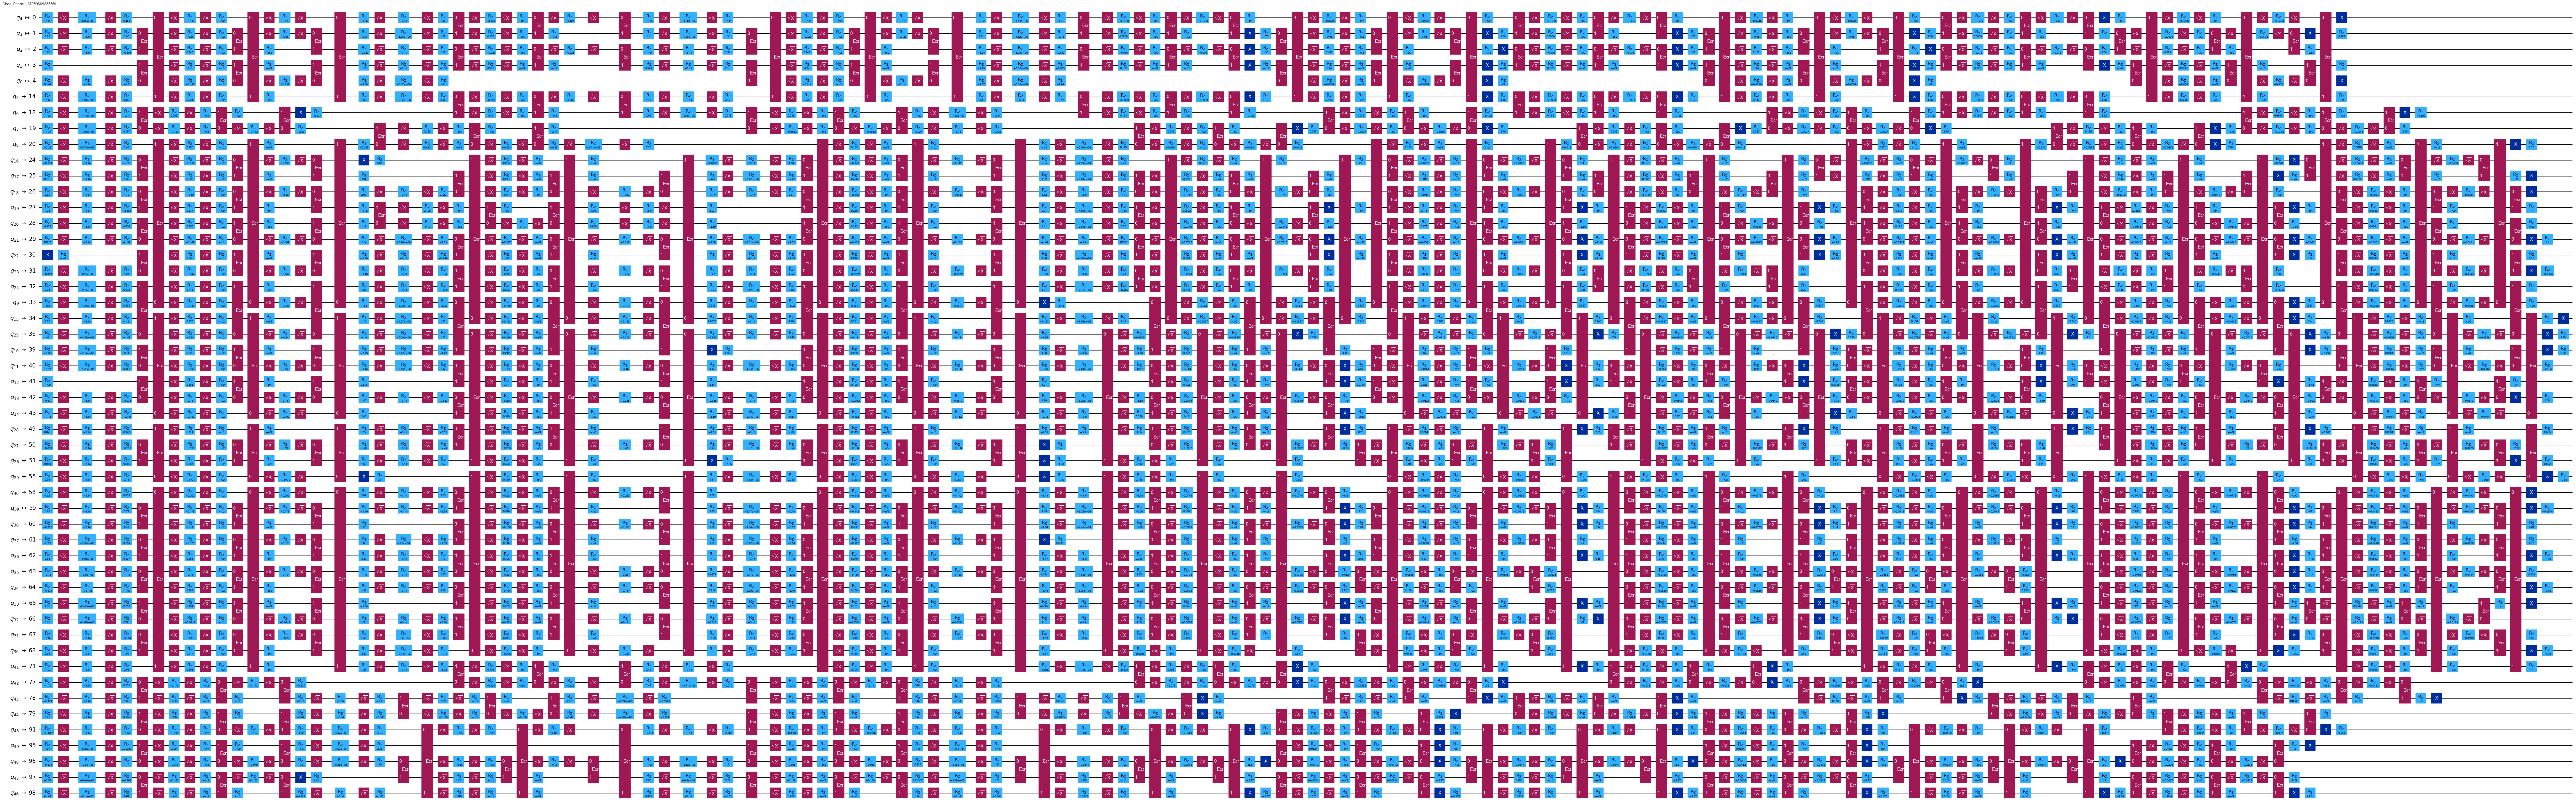

In [71]:
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 158


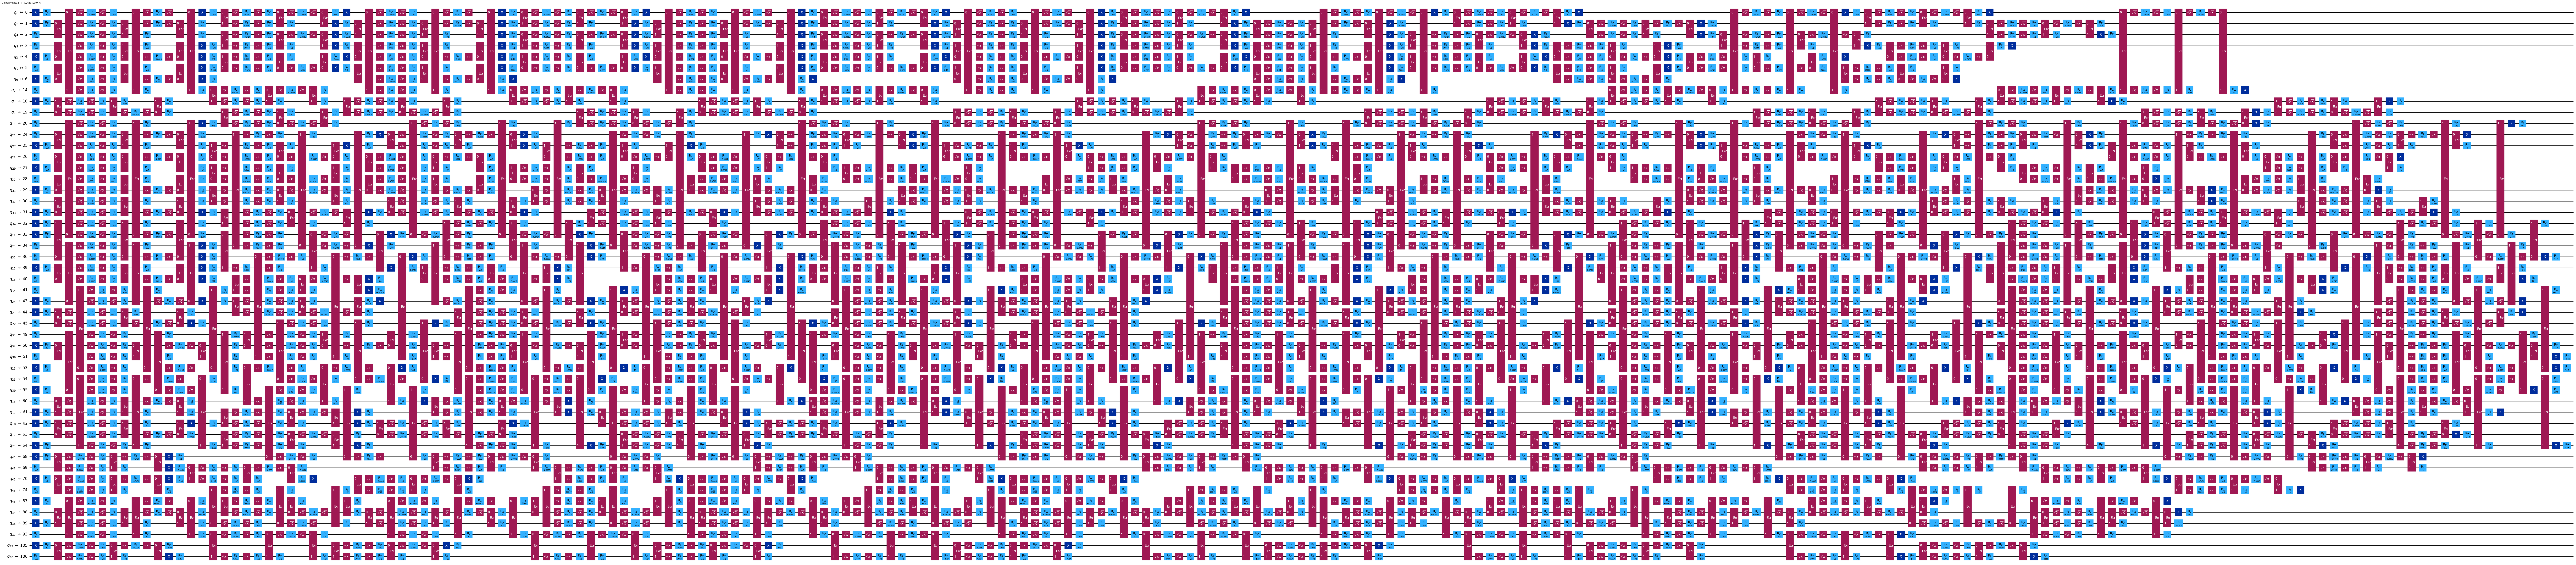

In [72]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

In [73]:
twirling_options = {
    "enable_gates": True,
    "enable_measure": True,
    "num_randomizations": 300,
    "shots_per_randomization": 100,
    "strategy": "active",
}

zne_options = {
    "amplifier": "gate_folding",
    "noise_factors": [1, 2, 3],
    "extrapolated_noise_factors": list(np.linspace(0, 3, 31)),
    "extrapolator": ["exponential", "linear", "fallback"],
}

meas_learning_options = {"num_randomizations": 512, "shots_per_randomization": 512}

resilience_options = {
    "measure_mitigation": True,
    "zne_mitigation": True,
    "zne": zne_options,
    "measure_noise_learning": meas_learning_options,
}

estimator_options = {
    "resilience": resilience_options,
    "twirling": twirling_options,
}

estimator = Estimator(backend, options=estimator_options)

In [74]:
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: cznxvkpd8drg008g93qg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

In [75]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: cznxvkpd8drg008g93qg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

In [76]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.5888
AQC:           	-0.5711, |∆| = 0.0176
AQC Comparison:	0.9940, |∆| = 1.5827


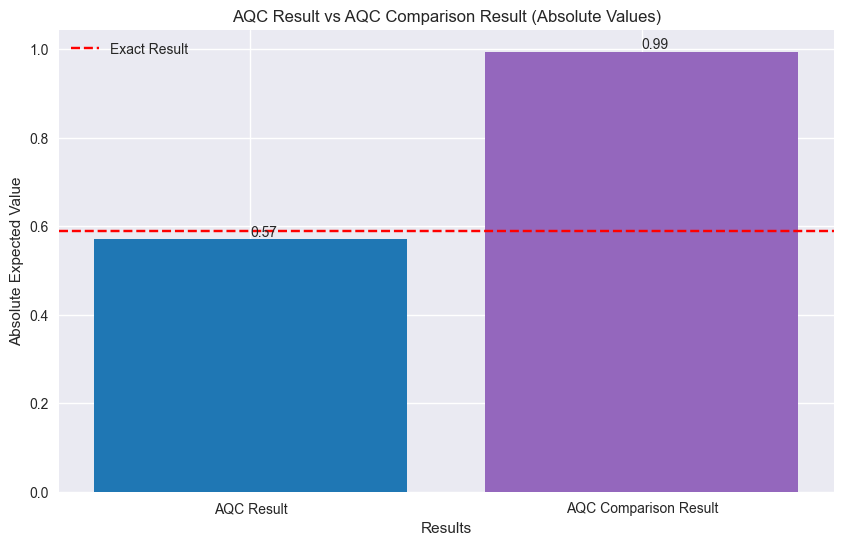

In [77]:
labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()